In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 

# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

from matplotlib import pyplot as plt
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys


INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


In [22]:
def get_dihedrals(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 0 # of replica
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
#     all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
#         all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
        all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    # write for loop for this part -- old and new atoms
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
#         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
        dihedrals_all.append(dihedrals)
    return dihedrals_all[0], dihedrals_all[1], n_iter
        
def get_dihedrals_last_replica(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    index = 10 # of replica
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
#     all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
        pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
        all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
#         all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
        all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

    dihedrals_all = []
    # write for loop for this part -- old and new atoms
    for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
        traj = md.Trajectory(np.array(pos), top)
#         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
        dihedrals = md.compute_dihedrals(traj, np.array([indices]))
        dihedrals_all.append(dihedrals)
    return dihedrals_all[0], dihedrals_all[1], n_iter
        
def get_dihedrals_all_replicas(i, aa, length, out_dir, htf, dihedral_indices_new, dihedral_indices_old):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)
    
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    
    from tqdm import tqdm
    dihedrals_master = []
    for i in range(11):
        index = i # of replica
        all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
        all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
#         all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
        for iteration in tqdm(range(n_iter)):
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
            pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
            all_pos_new[iteration] = htf.new_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
#             all_pos_hybrid[iteration] = pos.value_in_unit_system(unit.md_unit_system) # Get hybrid positions
            all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)

        dihedrals_all = []
        # write for loop for this part -- old and new atoms
        for pos, top, indices in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new, dihedral_indices_old]):
            traj = md.Trajectory(np.array(pos), top)
    #         dihedrals = np.sin(md.compute_dihedrals(traj, np.array([indices]))) 
            dihedrals = md.compute_dihedrals(traj, np.array([indices]))
            dihedrals_all.append(dihedrals)
        dihedrals_master.append(dihedrals_all)
    return dihedrals_master, n_iter
    
def plot_dihedrals(dihedrals, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals)
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.savefig(outfile, dpi=300)
    plt.close()
#     plt.show()
    
def plot_time_series(dihedrals, n_iter, outfile):
    from perses.dispersed import feptasks
    t0, g, neff_max, a_t, uncorrelated_indices = feptasks.compute_timeseries(dihedrals)

    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("sin(dihedral)")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.savefig(outfile, dpi=300)
    plt.close()
#     plt.show()
    
    return uncorrelated_indices
    
def plot_dihedrals_uncorrelated(dihedrals, uncorrelated_indices, outfile):
    # Plot histogram with error bars : https://stackoverflow.com/questions/35390276/how-to-add-error-bars-to-histogram-diagram-in-python
    entries, edges, _ = plt.hist(dihedrals[uncorrelated_indices])
    bin_centers = 0.5 * (edges[:-1] + edges[1:]) # calculate bin centers
    plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.') # draw errobars, use the sqrt error
    plt.xlim(-np.pi, np.pi)
    plt.savefig(outfile, dpi=300)
    plt.close()
#     plt.show()

# THR -> ALA (flattened) vacuum

### Lambda = 0, new (ALA)

In [3]:
i = 9
aa = 'thr' # lambda = 0
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [5]:
with open(os.path.join(out_dir, f"{i}_vacuum.pickle"), 'rb') as f:
    htf_0 = pickle.load(f)

In [6]:
for atom in htf_0._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (H) of chain 0 residue 1 (THR)>
<Atom 8 (CA) of chain 0 residue 1 (THR)>
<Atom 9 (HA) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (C) of chain 0 residue 1 (THR)>
<Atom 12 (O) of chain 0 residue 1 (THR)>
<Atom 13 (HB) of chain 0 residue 1 (THR)>
<Atom 14 (CG2) of chain 0 residue 1 (THR)>
<Atom 15 (HG21) of chain 0 residue 1 (THR)>
<Atom 16 (HG22) of chain 0 residue 1 (THR)>
<Atom 17 (HG23) of chain 0 residue 1 (THR)>
<Atom 18 (OG1) of chain 0 residue 1 (THR)>
<Atom 19 (HG1) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (H) of chain 0 residue 2 (NME)>
<Atom 22 (C) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [7]:
for atom in htf_0._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (H1) of chain 0 residue 0 (ACE)>
<Atom 1 (CH3) of chain 0 residue 0 (ACE)>
<Atom 2 (H2) of chain 0 residue 0 (ACE)>
<Atom 3 (H3) of chain 0 residue 0 (ACE)>
<Atom 4 (C) of chain 0 residue 0 (ACE)>
<Atom 5 (O) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (H) of chain 0 residue 1 (ALA)>
<Atom 8 (CA) of chain 0 residue 1 (ALA)>
<Atom 9 (HA) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (C) of chain 0 residue 1 (ALA)>
<Atom 12 (O) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (H) of chain 0 residue 2 (NME)>
<Atom 18 (C) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>


In [10]:
dihedrals, n_iter = get_dihedrals_all_replicas(i, aa, length, out_dir, htf_0, [13, 10, 8, 6], [18, 10, 8, 6])

100%|██████████| 5001/5001 [00:47<00:00, 105.20it/s]


In [24]:
from tqdm import tqdm
for j, replica in tqdm(enumerate(dihedrals)):
    dihedrals_new = replica[0]
    dihedrals_old = replica[1]
    plot_dihedrals(dihedrals_old, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_thr_correlated.png"))
    uncorrelated_old = plot_time_series(dihedrals_old, n_iter, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_thr_timeseries.png"))
    plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_thr_decorrelated.png"))
    plot_dihedrals(dihedrals_new, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_ala_correlated.png"))
    uncorrelated_new = plot_time_series(dihedrals_new, n_iter, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_ala_timeseries.png"))
    plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new, os.path.join(out_dir, f"{i}_vacuum_{aa}_{length}_{j}_ala_decorrelated.png"))

11it [01:23,  7.57s/it]


In [21]:
dihedrals[0][0].shape

(5001, 1)

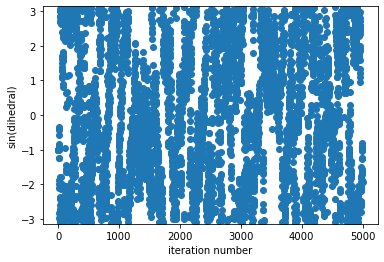

In [9]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


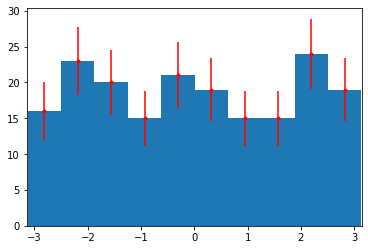

In [10]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (THR)

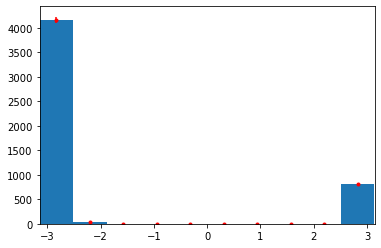

In [11]:
plot_dihedrals(dihedrals_old)

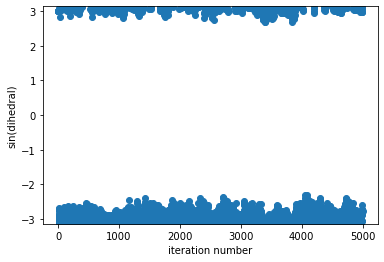

In [12]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

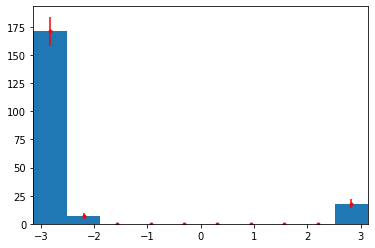

In [13]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

In [ ]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals_last_replica(i, aa, length, out_dir, htf_0, [13, 10, 7, 6], [12, 10, 7, 6])

 15%|█▌        | 759/5001 [02:57<16:24,  4.31it/s]

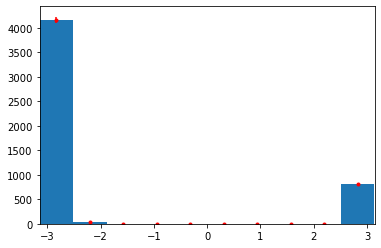

In [11]:
plot_dihedrals(dihedrals_old)

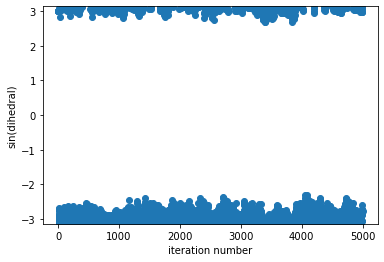

In [12]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

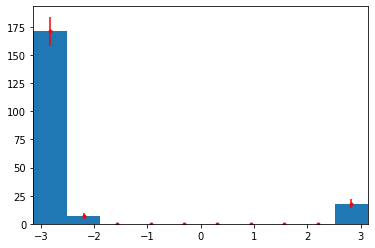

In [13]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (ALA)

In [14]:
i = 13
aa = 'ala' # lambda = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [15]:
with open(os.path.join(out_dir, f"{i}_solvent_1.pickle"), 'rb') as f:
    htf_1 = pickle.load(f)

In [16]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf_1, [13, 10, 7, 6], [12, 10, 7, 6])

100%|██████████| 5001/5001 [19:42<00:00,  4.23it/s]


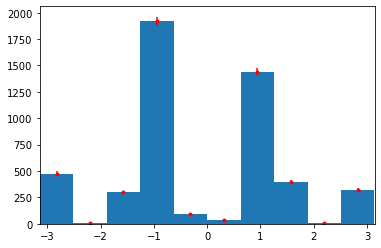

In [17]:
plot_dihedrals(dihedrals_new)

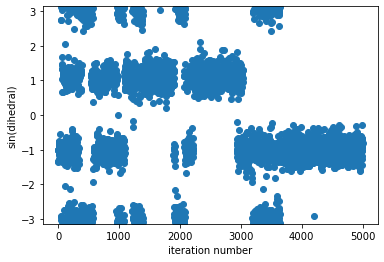

In [18]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


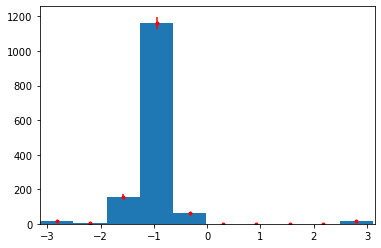

In [19]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (THR)

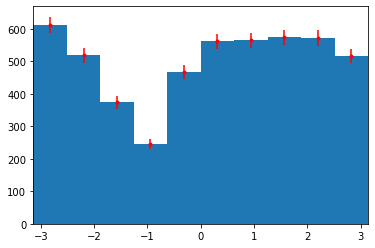

In [20]:
plot_dihedrals(dihedrals_old)

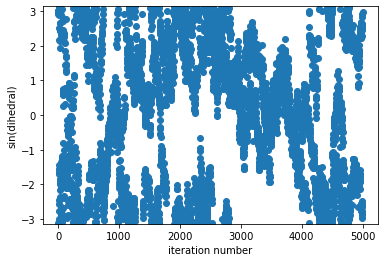

In [21]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

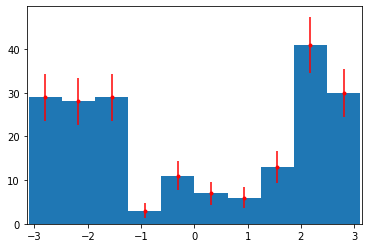

In [22]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

# THR -> ALA (WITHOUT flattened) solvent

### Lambda = 0, new (ALA)

In [23]:
i = 14
aa = 'thr' # lambda = 1
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [24]:
with open(os.path.join(out_dir, f"{i}_solvent_0.pickle"), 'rb') as f:
    htf_0 = pickle.load(f)

In [25]:
for atom in htf_0._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (C) of chain 0 residue 0 (ACE)>
<Atom 1 (O) of chain 0 residue 0 (ACE)>
<Atom 2 (CH3) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (THR)>
<Atom 7 (CA) of chain 0 residue 1 (THR)>
<Atom 8 (C) of chain 0 residue 1 (THR)>
<Atom 9 (O) of chain 0 residue 1 (THR)>
<Atom 10 (CB) of chain 0 residue 1 (THR)>
<Atom 11 (CG2) of chain 0 residue 1 (THR)>
<Atom 12 (OG1) of chain 0 residue 1 (THR)>
<Atom 13 (H) of chain 0 residue 1 (THR)>
<Atom 14 (HA) of chain 0 residue 1 (THR)>
<Atom 15 (HB) of chain 0 residue 1 (THR)>
<Atom 16 (HG1) of chain 0 residue 1 (THR)>
<Atom 17 (HG21) of chain 0 residue 1 (THR)>
<Atom 18 (HG22) of chain 0 residue 1 (THR)>
<Atom 19 (HG23) of chain 0 residue 1 (THR)>
<Atom 20 (N) of chain 0 residue 2 (NME)>
<Atom 21 (C) of chain 0 residue 2 (NME)>
<Atom 22 (H) of chain 0 residue 2 (NME)>
<Atom 23 (H1) of chain 0 residue 2 (NME)>
<

In [26]:
for atom in htf_0._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (C) of chain 0 residue 0 (ACE)>
<Atom 1 (O) of chain 0 residue 0 (ACE)>
<Atom 2 (CH3) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (CA) of chain 0 residue 1 (ALA)>
<Atom 8 (C) of chain 0 residue 1 (ALA)>
<Atom 9 (O) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (H) of chain 0 residue 1 (ALA)>
<Atom 12 (HA) of chain 0 residue 1 (ALA)>
<Atom 13 (HB1) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB3) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (NME)>
<Atom 17 (C) of chain 0 residue 2 (NME)>
<Atom 18 (H) of chain 0 residue 2 (NME)>
<Atom 19 (H1) of chain 0 residue 2 (NME)>
<Atom 20 (H2) of chain 0 residue 2 (NME)>
<Atom 21 (H3) of chain 0 residue 2 (NME)>
<Atom 22 (O) of chain 1 residue 3 (HOH)>
<Atom 23 (H1) of chain 1 residue 3 (HOH)>
<Atom 24

In [27]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf_0, [13, 10, 7, 6], [12, 10, 7, 6])

100%|██████████| 5001/5001 [19:37<00:00,  4.25it/s]


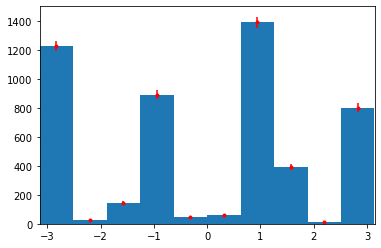

In [28]:
plot_dihedrals(dihedrals_new)

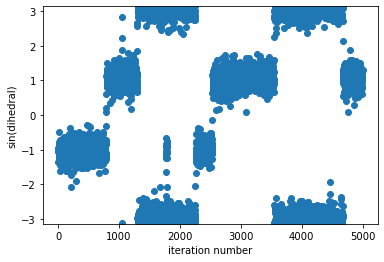

In [29]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


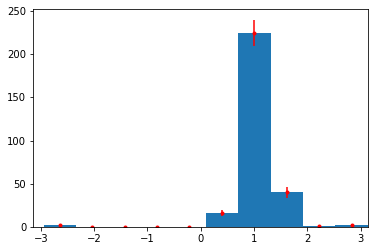

In [30]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (THR)

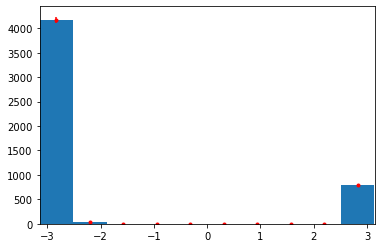

In [31]:
plot_dihedrals(dihedrals_old)

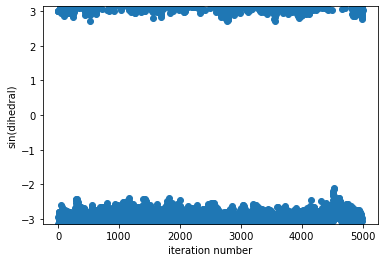

In [32]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

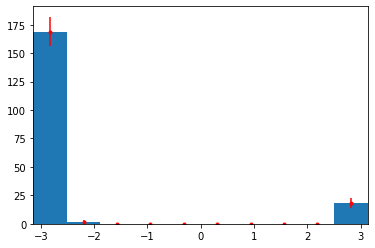

In [33]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (ALA)

In [34]:
i = 14
aa = 'ala'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [35]:
with open(os.path.join(out_dir, f"{i}_solvent_1.pickle"), 'rb') as f:
    htf_1 = pickle.load(f)

In [36]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf_1, [13, 10, 7, 6], [12, 10, 7, 6])

100%|██████████| 5001/5001 [19:34<00:00,  4.26it/s]


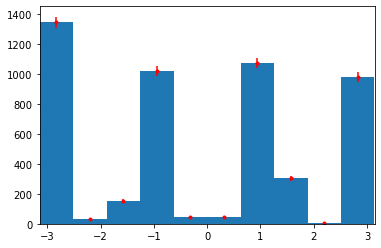

In [37]:
plot_dihedrals(dihedrals_new)

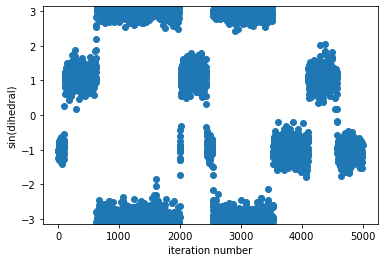

In [38]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


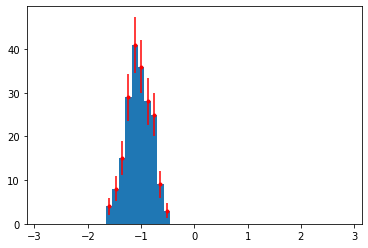

In [39]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (THR)

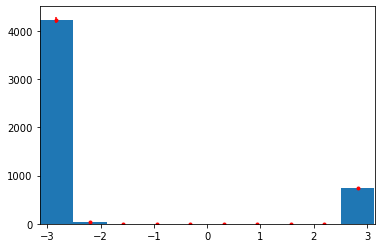

In [40]:
plot_dihedrals(dihedrals_old)

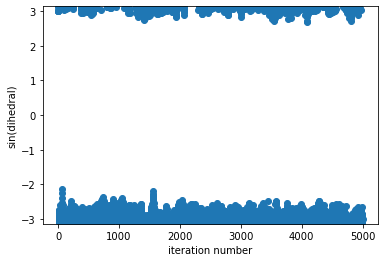

In [41]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

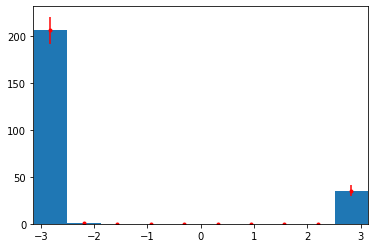

In [42]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

# 8-mer SER->ALA (flattened) solvent

### Lambda = 0, new (ALA)

In [43]:
i = 15
aa = 'ser'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [44]:
with open(os.path.join(out_dir, f"{i}_solvent_0.pickle"), 'rb') as f:
    htf_0 = pickle.load(f)

In [45]:
for atom in htf_0._topology_proposal.old_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (SER)>
<Atom 7 (CA) of chain 0 residue 1 (SER)>
<Atom 8 (C) of chain 0 residue 1 (SER)>
<Atom 9 (O) of chain 0 residue 1 (SER)>
<Atom 10 (CB) of chain 0 residue 1 (SER)>
<Atom 11 (OG) of chain 0 residue 1 (SER)>
<Atom 12 (H) of chain 0 residue 1 (SER)>
<Atom 13 (HA) of chain 0 residue 1 (SER)>
<Atom 14 (HB3) of chain 0 residue 1 (SER)>
<Atom 15 (HB2) of chain 0 residue 1 (SER)>
<Atom 16 (HG) of chain 0 residue 1 (SER)>
<Atom 17 (N) of chain 0 residue 2 (ALA)>
<Atom 18 (CA) of chain 0 residue 2 (ALA)>
<Atom 19 (C) of chain 0 residue 2 (ALA)>
<Atom 20 (O) of chain 0 residue 2 (ALA)>
<Atom 21 (CB) of chain 0 residue 2 (ALA)>
<Atom 22 (H) of chain 0 residue 2 (ALA)>
<Atom 23 (HA) of chain 0 residue 2 (ALA)>
<Atom 24 

<Atom 3953 (H2) of chain 1 residue 1286 (HOH)>
<Atom 3954 (O) of chain 1 residue 1287 (HOH)>
<Atom 3955 (H1) of chain 1 residue 1287 (HOH)>
<Atom 3956 (H2) of chain 1 residue 1287 (HOH)>
<Atom 3957 (O) of chain 1 residue 1288 (HOH)>
<Atom 3958 (H1) of chain 1 residue 1288 (HOH)>
<Atom 3959 (H2) of chain 1 residue 1288 (HOH)>
<Atom 3960 (O) of chain 1 residue 1289 (HOH)>
<Atom 3961 (H1) of chain 1 residue 1289 (HOH)>
<Atom 3962 (H2) of chain 1 residue 1289 (HOH)>
<Atom 3963 (O) of chain 1 residue 1290 (HOH)>
<Atom 3964 (H1) of chain 1 residue 1290 (HOH)>
<Atom 3965 (H2) of chain 1 residue 1290 (HOH)>
<Atom 3966 (O) of chain 1 residue 1291 (HOH)>
<Atom 3967 (H1) of chain 1 residue 1291 (HOH)>
<Atom 3968 (H2) of chain 1 residue 1291 (HOH)>
<Atom 3969 (O) of chain 1 residue 1292 (HOH)>
<Atom 3970 (H1) of chain 1 residue 1292 (HOH)>
<Atom 3971 (H2) of chain 1 residue 1292 (HOH)>
<Atom 3972 (O) of chain 1 residue 1293 (HOH)>
<Atom 3973 (H1) of chain 1 residue 1293 (HOH)>
<Atom 3974 (H2) of c

In [46]:
for atom in htf_0._topology_proposal.new_topology.atoms():
    print(atom)

<Atom 0 (CH3) of chain 0 residue 0 (ACE)>
<Atom 1 (C) of chain 0 residue 0 (ACE)>
<Atom 2 (O) of chain 0 residue 0 (ACE)>
<Atom 3 (H1) of chain 0 residue 0 (ACE)>
<Atom 4 (H2) of chain 0 residue 0 (ACE)>
<Atom 5 (H3) of chain 0 residue 0 (ACE)>
<Atom 6 (N) of chain 0 residue 1 (ALA)>
<Atom 7 (CA) of chain 0 residue 1 (ALA)>
<Atom 8 (C) of chain 0 residue 1 (ALA)>
<Atom 9 (O) of chain 0 residue 1 (ALA)>
<Atom 10 (CB) of chain 0 residue 1 (ALA)>
<Atom 11 (H) of chain 0 residue 1 (ALA)>
<Atom 12 (HA) of chain 0 residue 1 (ALA)>
<Atom 13 (HB3) of chain 0 residue 1 (ALA)>
<Atom 14 (HB2) of chain 0 residue 1 (ALA)>
<Atom 15 (HB1) of chain 0 residue 1 (ALA)>
<Atom 16 (N) of chain 0 residue 2 (ALA)>
<Atom 17 (CA) of chain 0 residue 2 (ALA)>
<Atom 18 (C) of chain 0 residue 2 (ALA)>
<Atom 19 (O) of chain 0 residue 2 (ALA)>
<Atom 20 (CB) of chain 0 residue 2 (ALA)>
<Atom 21 (H) of chain 0 residue 2 (ALA)>
<Atom 22 (HA) of chain 0 residue 2 (ALA)>
<Atom 23 (HB1) of chain 0 residue 2 (ALA)>
<Atom 2

<Atom 2372 (O) of chain 1 residue 760 (HOH)>
<Atom 2373 (H1) of chain 1 residue 760 (HOH)>
<Atom 2374 (H2) of chain 1 residue 760 (HOH)>
<Atom 2375 (O) of chain 1 residue 761 (HOH)>
<Atom 2376 (H1) of chain 1 residue 761 (HOH)>
<Atom 2377 (H2) of chain 1 residue 761 (HOH)>
<Atom 2378 (O) of chain 1 residue 762 (HOH)>
<Atom 2379 (H1) of chain 1 residue 762 (HOH)>
<Atom 2380 (H2) of chain 1 residue 762 (HOH)>
<Atom 2381 (O) of chain 1 residue 763 (HOH)>
<Atom 2382 (H1) of chain 1 residue 763 (HOH)>
<Atom 2383 (H2) of chain 1 residue 763 (HOH)>
<Atom 2384 (O) of chain 1 residue 764 (HOH)>
<Atom 2385 (H1) of chain 1 residue 764 (HOH)>
<Atom 2386 (H2) of chain 1 residue 764 (HOH)>
<Atom 2387 (O) of chain 1 residue 765 (HOH)>
<Atom 2388 (H1) of chain 1 residue 765 (HOH)>
<Atom 2389 (H2) of chain 1 residue 765 (HOH)>
<Atom 2390 (O) of chain 1 residue 766 (HOH)>
<Atom 2391 (H1) of chain 1 residue 766 (HOH)>
<Atom 2392 (H2) of chain 1 residue 766 (HOH)>
<Atom 2393 (O) of chain 1 residue 767 (HO

<Atom 3871 (H2) of chain 1 residue 1259 (HOH)>
<Atom 3872 (O) of chain 1 residue 1260 (HOH)>
<Atom 3873 (H1) of chain 1 residue 1260 (HOH)>
<Atom 3874 (H2) of chain 1 residue 1260 (HOH)>
<Atom 3875 (O) of chain 1 residue 1261 (HOH)>
<Atom 3876 (H1) of chain 1 residue 1261 (HOH)>
<Atom 3877 (H2) of chain 1 residue 1261 (HOH)>
<Atom 3878 (O) of chain 1 residue 1262 (HOH)>
<Atom 3879 (H1) of chain 1 residue 1262 (HOH)>
<Atom 3880 (H2) of chain 1 residue 1262 (HOH)>
<Atom 3881 (O) of chain 1 residue 1263 (HOH)>
<Atom 3882 (H1) of chain 1 residue 1263 (HOH)>
<Atom 3883 (H2) of chain 1 residue 1263 (HOH)>
<Atom 3884 (O) of chain 1 residue 1264 (HOH)>
<Atom 3885 (H1) of chain 1 residue 1264 (HOH)>
<Atom 3886 (H2) of chain 1 residue 1264 (HOH)>
<Atom 3887 (O) of chain 1 residue 1265 (HOH)>
<Atom 3888 (H1) of chain 1 residue 1265 (HOH)>
<Atom 3889 (H2) of chain 1 residue 1265 (HOH)>
<Atom 3890 (O) of chain 1 residue 1266 (HOH)>
<Atom 3891 (H1) of chain 1 residue 1266 (HOH)>
<Atom 3892 (H2) of c

In [47]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf_0, [15, 10, 7, 6], [11, 10, 7, 6])

100%|██████████| 5001/5001 [1:10:00<00:00,  1.19it/s]


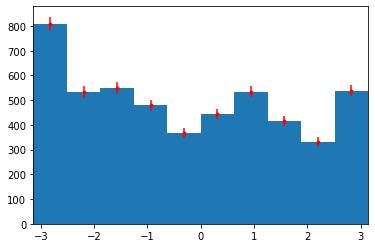

In [48]:
plot_dihedrals(dihedrals_new)

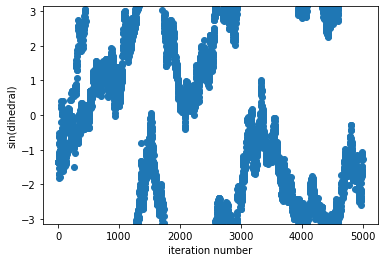

In [49]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


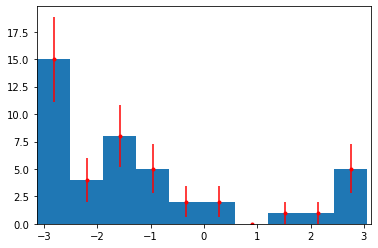

In [50]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 0, old (SER)

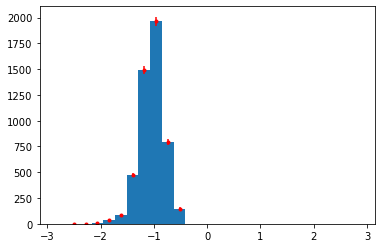

In [51]:
plot_dihedrals(dihedrals_old)

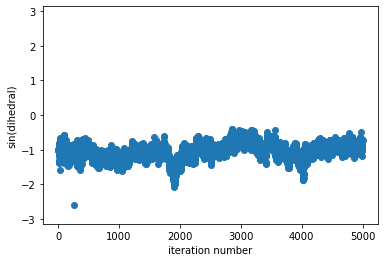

In [52]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

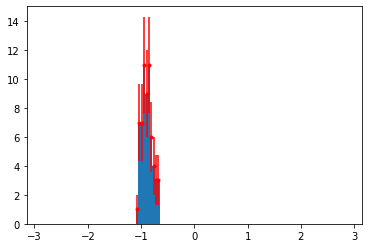

In [53]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)

### Lambda = 1, new (ALA)

In [54]:
i = 15
aa = 'ala'
length = '5ns'
out_dir = f"/data/chodera/zhangi/perses_benchmark/neq/10/{i}/"

In [55]:
with open(os.path.join(out_dir, f"{i}_solvent_1.pickle"), 'rb') as f:
    htf_1 = pickle.load(f)

In [56]:
dihedrals_new, dihedrals_old, n_iter = get_dihedrals(i, aa, length, out_dir, htf_1, [15, 10, 7, 6], [11, 10, 7, 6])

100%|██████████| 5001/5001 [1:10:00<00:00,  1.19it/s]


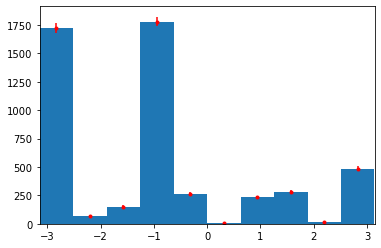

In [57]:
plot_dihedrals(dihedrals_new)

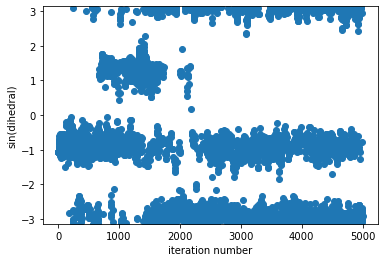

In [58]:
uncorrelated_new = plot_time_series(dihedrals_new, n_iter)


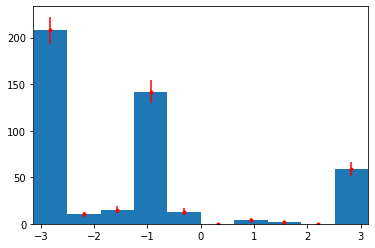

In [59]:
plot_dihedrals_uncorrelated(dihedrals_new, uncorrelated_new)

### Lambda = 1, old (SER)

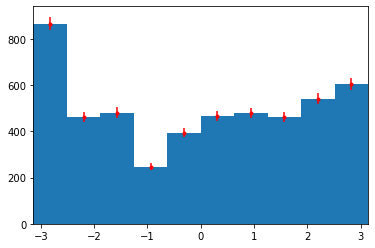

In [60]:
plot_dihedrals(dihedrals_old)

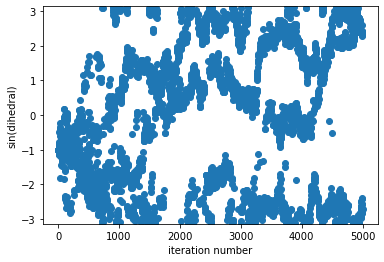

In [61]:
uncorrelated_old = plot_time_series(dihedrals_old, n_iter)

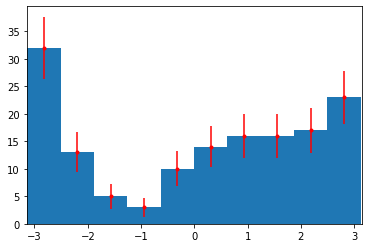

In [62]:
plot_dihedrals_uncorrelated(dihedrals_old, uncorrelated_old)